In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/braintumor/BrainTumorData/2912.mat
/kaggle/input/braintumor/BrainTumorData/2011.mat
/kaggle/input/braintumor/BrainTumorData/3027.mat
/kaggle/input/braintumor/BrainTumorData/1912.mat
/kaggle/input/braintumor/BrainTumorData/3023.mat
/kaggle/input/braintumor/BrainTumorData/101.mat
/kaggle/input/braintumor/BrainTumorData/1194.mat
/kaggle/input/braintumor/BrainTumorData/851.mat
/kaggle/input/braintumor/BrainTumorData/2106.mat
/kaggle/input/braintumor/BrainTumorData/1850.mat
/kaggle/input/braintumor/BrainTumorData/2911.mat
/kaggle/input/braintumor/BrainTumorData/1731.mat
/kaggle/input/braintumor/BrainTumorData/1014.mat
/kaggle/input/braintumor/BrainTumorData/296.mat
/kaggle/input/braintumor/BrainTumorData/1716.mat
/kaggle/input/braintumor/BrainTumorData/124.mat
/kaggle/input/braintumor/BrainTumorData/2541.mat
/kaggle/input/braintumor/BrainTumorData/1082.mat
/kaggle/input/braintumor/BrainTumorData/1719.mat
/kaggle/input/braintumor/BrainTumorData/2551.mat
/kaggle/input/braintumor

/kaggle/input/braintumor/BrainTumorData/2654.mat
/kaggle/input/braintumor/BrainTumorData/438.mat
/kaggle/input/braintumor/BrainTumorData/2764.mat
/kaggle/input/braintumor/BrainTumorData/999.mat
/kaggle/input/braintumor/BrainTumorData/420.mat
/kaggle/input/braintumor/BrainTumorData/433.mat
/kaggle/input/braintumor/BrainTumorData/1624.mat
/kaggle/input/braintumor/BrainTumorData/1718.mat
/kaggle/input/braintumor/BrainTumorData/913.mat
/kaggle/input/braintumor/BrainTumorData/1183.mat
/kaggle/input/braintumor/BrainTumorData/1790.mat
/kaggle/input/braintumor/BrainTumorData/2617.mat
/kaggle/input/braintumor/BrainTumorData/2825.mat
/kaggle/input/braintumor/BrainTumorData/2753.mat
/kaggle/input/braintumor/BrainTumorData/59.mat
/kaggle/input/braintumor/BrainTumorData/2326.mat
/kaggle/input/braintumor/BrainTumorData/1098.mat
/kaggle/input/braintumor/BrainTumorData/995.mat
/kaggle/input/braintumor/BrainTumorData/48.mat
/kaggle/input/braintumor/BrainTumorData/1667.mat
/kaggle/input/braintumor/Brain

In [2]:
os.mkdir('./output')

## Utils.py

In [3]:
# from keras.layers import Lambda
# import tensorflow as tf
# from skimage import data, io, filters
# import numpy as np
# from numpy import array
# from numpy.random import randint
# # from scipy.misc import imresize
# from skimage.transform import resize
# import os
# import sys

# import matplotlib.pyplot as plt
# plt.switch_backend('agg')

## Network.py

In [4]:
# !pip install -U tensorflow==1.11.0

In [5]:
# Modules
from keras.layers import Dense
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import add

In [6]:
# Residual block
def res_block_gen(model, kernal_size, filters, strides):
    
    gen = model
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
        
    model = add([gen, model])
    
    return model

In [7]:
def up_sampling_block(model, kernal_size, filters, strides):
    
    # In place of Conv2D and UpSampling2D we can also use Conv2DTranspose (Both are used for Deconvolution)
    # Even we can have our own function for deconvolution (i.e one made in Utils.py)
    #model = Conv2DTranspose(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model

In [8]:
def discriminator_block(model, filters, kernel_size, strides):
    
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model

In [9]:
# Network Architecture is same as given in Paper https://arxiv.org/pdf/1609.04802.pdf
class Generator(object):

    def __init__(self, noise_shape):
        
        self.noise_shape = noise_shape

    def generator(self):
        
        gen_input = Input(shape = self.noise_shape)
        print('generator input:  ',gen_input.shape)

        model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
        model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)

        gen_model = model

        # Using 16 Residual Blocks
        for index in range(16):
            model = res_block_gen(model, 3, 64, 1)

        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
        model = BatchNormalization(momentum = 0.5)(model)
        model = add([gen_model, model])

        # Using 2 UpSampling Blocks
        for index in range(2):
            model = up_sampling_block(model, 3, 256, 1)

        model = Conv2D(filters = 1, kernel_size = 9, strides = 1, padding = "same")(model)
        model = Activation('tanh')(model)

        generator_model = Model(inputs = gen_input, outputs = model)
        print('output of generator: ', generator_model)

        return generator_model

In [10]:
# Network Architecture is same as given in Paper https://arxiv.org/pdf/1609.04802.pdf
class Discriminator(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape
    
    def discriminator(self):
        
        dis_input = Input(shape = self.image_shape)
        print('discriminator input: ', dis_input.shape)
        
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
        model = LeakyReLU(alpha = 0.2)(model)
        
        model = discriminator_block(model, 64, 3, 2)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 2)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 2)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 2)
        
        model = Flatten()(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha = 0.2)(model)
       
        model = Dense(1)(model)
        model = Activation('sigmoid')(model) 
        
        discriminator_model = Model(inputs = dis_input, outputs = model)
        print('Discriminator output: ', discriminator_model)
        return discriminator_model

## train.py

In [11]:
# from Network import Generator, Discriminator

import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras.applications.vgg19 import VGG19
from keras.layers.convolutional import UpSampling2D
from keras.models import Model
from keras.optimizers import SGD, Adam, RMSprop
import keras
import keras.backend as K
from keras.layers import Lambda, Input
import tensorflow as tf
import skimage.transform
from skimage import data, io, filters
import numpy as np
from numpy import array
from skimage.transform import rescale, resize
from skimage.transform import resize
import os


from matplotlib.pyplot import imread
import h5py
import cv2

np.random.seed(10)
# image_shape = (384,384,3)
image_shape = (512,512,1)

In [12]:
tf.__version__

'2.3.1'

In [13]:
# def vgg_loss(y_true, y_pred):
    
# #     vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=image_shape)
#     vgg19 = VGG19(include_top=False, weights='imagenet')
#     vgg19.trainable = False
#     for l in vgg19.layers:
#         l.trainable = False
#     input_tensor = Input(shape=image_shape)
#     x = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = "same")(input_tensor)
# #     out = vgg19(x)
# #     loss_model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
#     loss_model = Model(inputs=x, outputs=vgg19.get_layer('block5_conv4').output)
#     loss_model.trainable = False
#     return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

In [14]:
def get_gan_network(discriminator, shape, generator, optimizer):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
#     gan.compile(loss=[vgg_loss, "binary_crossentropy"],
#                 loss_weights=[1., 1e-3],
#                 optimizer=optimizer)
    gan.compile(loss=["binary_crossentropy", "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=optimizer)

    return gan

In [15]:
def load_path(path):
    directories = []
    if os.path.isdir(path):
        print('directory path: ', path)
        directories.append(path)
    for elem in os.listdir(path): #check for nested dir within parent dir
        if os.path.isdir(os.path.join(path,elem)):
            print('inside nested dir')
            directories = directories + load_path(os.path.join(path,elem))
            directories.append(os.path.join(path,elem))
    print('directories: ', directories)
    return directories

In [16]:
def load_data_from_dirs(dirs, ext):
    files = []
    file_names = []
    count = 0
    for d in dirs:
#         print('Directory: ', d)
        for f in os.listdir(d):
#             print('File: ', f)
            if f.endswith(ext):
#                 image = imread(os.path.join(d,f))
                image = h5py.File(os.path.join(d,f), 'r')
#                 if len(image.shape) > 2:
#                     files.append(image)
#                     file_names.append(os.path.join(d,f))
                files.append(image)
                file_names.append(os.path.join(d,f))
                count = count + 1
    print('list of files: ',len(files), 'file: ', files[0])
    print('list of files path: ', len(file_names), 'file path: ', file_names[0])
    print('Files Read: ',count)
    return files   

In [17]:
# def load_data_from_dirs_resize(dirs, ext, size):
#     files = []
#     file_names = []
#     count = 0
#     for d in dirs:
#         for f in os.listdir(d): 
#             if f.endswith(ext):
#                 files.append(resize(data.imread(os.path.join(d,f)), size))
#                 file_names.append(os.path.join(d,f))
#                 count = count + 1
#     return files 

In [18]:
def load_data(directory, ext):

    files = load_data_from_dirs(load_path(directory), ext)
    return files

In [19]:
files = load_data("../input/braintumor/BrainTumorData/", ".mat")
# files = load_data("../input/normalxray/normal_xray/", ".jpeg")
x_train_h5 = files[:500]
x_test_h5 = files[600:900]
# x_train = files[:50]
# x_test = files[50:101]

directory path:  ../input/braintumor/BrainTumorData/
directories:  ['../input/braintumor/BrainTumorData/']
list of files:  3064 file:  <HDF5 file "2912.mat" (mode r)>
list of files path:  3064 file path:  ../input/braintumor/BrainTumorData/2912.mat
Files Read:  3064


In [20]:
print('Total files: ',len(files),' x_train: ', len(x_train_h5),' x_test', len(x_test_h5))

Total files:  3064  x_train:  500  x_test 300


In [21]:
print(x_train_h5[0], x_train_h5[1])

<HDF5 file "2912.mat" (mode r)> <HDF5 file "2011.mat" (mode r)>


In [22]:
print(x_train_h5[0].keys())
print(x_train_h5[0]['cjdata'])
print(x_train_h5[0]['cjdata']['PID'])
print(x_train_h5[0]['cjdata']['image'])
print(x_train_h5[0]['cjdata']['label'])
print(x_train_h5[0]['cjdata']['tumorBorder'])
print(x_train_h5[0]['cjdata']['tumorMask'])

<KeysViewHDF5 ['cjdata']>
<HDF5 group "/cjdata" (5 members)>
<HDF5 dataset "PID": shape (9, 1), type "<u2">
<HDF5 dataset "image": shape (512, 512), type "<i2">
<HDF5 dataset "label": shape (1, 1), type "<f8">
<HDF5 dataset "tumorBorder": shape (1, 30), type "<f8">
<HDF5 dataset "tumorMask": shape (512, 512), type "|u1">


In [23]:
print(x_train_h5[0]['cjdata']['PID'].value)
print(x_train_h5[0]['cjdata']['image'].value)
print(x_train_h5[0]['cjdata']['label'].value)
print(x_train_h5[0]['cjdata']['tumorBorder'].value)
print(x_train_h5[0]['cjdata']['tumorMask'].value)

[[77]
 [82]
 [48]
 [53]
 [48]
 [55]
 [57]
 [49]
 [66]]
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 3  3 14 ... 14 13 13]
 [ 3  3 12 ... 12 11 11]
 [ 2  2 11 ...  8 10 10]]
[[2.]]
[[294.3554007  240.83623693 322.00696864 239.94425087 349.65853659
  247.08013937 382.66202091 258.67595819 394.25783972 265.81184669
  396.04181185 276.51567944 393.36585366 291.67944251 379.98606272
  313.08710801 366.60627178 322.8989547  361.2543554  322.8989547
  360.36236934 302.38327526 355.01045296 278.29965157 349.65853659
  264.02787456 325.57491289 249.75609756 305.05923345 246.18815331]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """


In [24]:
x_train = [np.expand_dims(array(mat['cjdata']['image'].value), axis=2) for mat in x_train_h5]
x_test = [np.expand_dims(array(mat['cjdata']['image'].value), axis=2) for mat in x_test_h5]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [25]:
print(type(x_train),x_train[0].shape, type(x_test[0]))

<class 'list'> (512, 512, 1) <class 'numpy.ndarray'>


In [26]:
def hr_images(images):
#     images_hr = [image.ravel() for image in images]
    images_hr = array(images)
    return images_hr

In [27]:
def lr_images(images_real , downscale):
    
    images = []
    for img in  range(len(images_real)):
        im = cv2.resize(images_real[img], 
                                 (images_real[img].shape[0]//downscale,images_real[img].shape[1]//downscale),
                                 interpolation=cv2.INTER_CUBIC)
        images.append(np.expand_dims(im,axis=2))
    images_lr = array(images)
    return images_lr

In [28]:
def preprocess_HR(x):
    return np.divide(x.astype(np.float32), 127.5) - np.ones_like(x,dtype=np.float32)

In [29]:
def deprocess_HR(x):
    input_data = (input_data + 1) * 127.5
    return input_data.astype(np.uint8) 

In [30]:
def preprocess_LR(x):
    return np.divide(x.astype(np.float32), 255.)


In [31]:
def deprocess_LR(x):
    x = np.clip(x*255, 0, 255)
    return x

In [32]:
def normalize(input_data):
    input_data_normalize = [(img.astype(np.float32) - 127.5)/127.5 for img in input_data]
#     input_data_normalize = [img.reshape((512,512)) for img in input_data_normalize]
    return array(input_data_normalize)
#     return (input_data.astype(np.float32) - 127.5)/127.5 

In [33]:
def denormalize(input_data):
    input_data = array([(img.astype(np.float32) + 1) * 127.5 for img in input_data])
    return input_data.astype(np.uint8) 

In [34]:
def deprocess_LRS(x):
    x = np.clip(x*255, 0, 255)
    return x.astype(np.uint8)

In [35]:
x_train[0]

array([[[ 0],
        [ 0],
        [ 0],
        ...,
        [ 0],
        [ 0],
        [ 0]],

       [[ 0],
        [ 0],
        [ 0],
        ...,
        [ 0],
        [ 0],
        [ 0]],

       [[ 0],
        [ 0],
        [ 0],
        ...,
        [ 0],
        [ 0],
        [ 0]],

       ...,

       [[ 3],
        [ 3],
        [14],
        ...,
        [14],
        [13],
        [13]],

       [[ 3],
        [ 3],
        [12],
        ...,
        [12],
        [11],
        [11]],

       [[ 2],
        [ 2],
        [11],
        ...,
        [ 8],
        [10],
        [10]]], dtype=int16)

In [36]:
x_train_hr = hr_images(x_train)
print(x_train_hr.shape)
print(x_train_hr[0].shape)
print(x_train_hr[1].shape)
print(x_train_hr[2].shape)

(500,)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)


In [37]:
x_train_hr = normalize(x_train_hr)

In [38]:
print(x_train_hr.shape)
print(x_train_hr[0].shape)
print(x_train_hr[1].shape)
print(x_train_hr[2].shape)
print(x_train[0])

(500,)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
[[[ 0]
  [ 0]
  [ 0]
  ...
  [ 0]
  [ 0]
  [ 0]]

 [[ 0]
  [ 0]
  [ 0]
  ...
  [ 0]
  [ 0]
  [ 0]]

 [[ 0]
  [ 0]
  [ 0]
  ...
  [ 0]
  [ 0]
  [ 0]]

 ...

 [[ 3]
  [ 3]
  [14]
  ...
  [14]
  [13]
  [13]]

 [[ 3]
  [ 3]
  [12]
  ...
  [12]
  [11]
  [11]]

 [[ 2]
  [ 2]
  [11]
  ...
  [ 8]
  [10]
  [10]]]


In [39]:
x_train_lr = lr_images(x_train, 4)

In [40]:
print(x_train_lr.shape)
print(x_train_lr[0].shape)
print(x_train_lr[1].shape)
print(x_train_lr[2].shape)
print(x_train[0])

(500,)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
[[[ 0]
  [ 0]
  [ 0]
  ...
  [ 0]
  [ 0]
  [ 0]]

 [[ 0]
  [ 0]
  [ 0]
  ...
  [ 0]
  [ 0]
  [ 0]]

 [[ 0]
  [ 0]
  [ 0]
  ...
  [ 0]
  [ 0]
  [ 0]]

 ...

 [[ 3]
  [ 3]
  [14]
  ...
  [14]
  [13]
  [13]]

 [[ 3]
  [ 3]
  [12]
  ...
  [12]
  [11]
  [11]]

 [[ 2]
  [ 2]
  [11]
  ...
  [ 8]
  [10]
  [10]]]


In [41]:
x_train_lr = normalize(x_train_lr)

In [42]:
print(x_train_lr.shape)
print(x_train_lr[0].shape)
print(x_train_lr[1].shape)
print(x_train_lr[2].shape)
print(x_train[0])

(500,)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
[[[ 0]
  [ 0]
  [ 0]
  ...
  [ 0]
  [ 0]
  [ 0]]

 [[ 0]
  [ 0]
  [ 0]
  ...
  [ 0]
  [ 0]
  [ 0]]

 [[ 0]
  [ 0]
  [ 0]
  ...
  [ 0]
  [ 0]
  [ 0]]

 ...

 [[ 3]
  [ 3]
  [14]
  ...
  [14]
  [13]
  [13]]

 [[ 3]
  [ 3]
  [12]
  ...
  [12]
  [11]
  [11]]

 [[ 2]
  [ 2]
  [11]
  ...
  [ 8]
  [10]
  [10]]]


In [43]:
x_test_hr = hr_images(x_test)
x_test_hr = normalize(x_test_hr)

In [44]:
print(x_test_hr[0].shape)

(512, 512, 1)


In [45]:
x_test_lr = lr_images(x_test, 4)
x_test_lr = normalize(x_test_lr)

In [46]:
from PIL import Image

In [47]:
img = Image.fromarray(x_train_lr[0].squeeze())
print(img.mode)
print(img.size)
print(img.format)

F
(128, 128)
None


In [48]:
print(x_test_lr[0].shape)

(128, 128, 1)


In [49]:
print("data processed")

data processed


In [50]:
# x_train_lr_new = []
# for i in range(len(x_train_lr)):
#     img = x_train_lr[i].reshape(128,128,1)
#     x_train_lr_new.append(img)

In [51]:
# print(x_train_lr_new[0].shape)

In [52]:
# x_train_lr_new = []
# for i in range(len(x_train_hr)):
#     img = x_train_lr[i].reshape(128,128,1)
#     x_train_lr_new.append(img)

In [53]:
# x_train_hr = array([cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) for img in x_train_hr])
# x_train_lr = array([cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) for img in x_train_lr])
# x_test_hr = array([cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) for img in x_test_hr])
# x_test_lr = array([cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) for img in x_test_lr])

In [54]:
print(array(x_train_hr).shape)

(500,)


In [55]:
for idx, img in enumerate(x_train_hr):
    print(idx+1,' Image: ',img.shape)

1  Image:  (512, 512, 1)
2  Image:  (512, 512, 1)
3  Image:  (512, 512, 1)
4  Image:  (512, 512, 1)
5  Image:  (512, 512, 1)
6  Image:  (512, 512, 1)
7  Image:  (512, 512, 1)
8  Image:  (512, 512, 1)
9  Image:  (512, 512, 1)
10  Image:  (512, 512, 1)
11  Image:  (512, 512, 1)
12  Image:  (512, 512, 1)
13  Image:  (512, 512, 1)
14  Image:  (512, 512, 1)
15  Image:  (512, 512, 1)
16  Image:  (512, 512, 1)
17  Image:  (512, 512, 1)
18  Image:  (512, 512, 1)
19  Image:  (512, 512, 1)
20  Image:  (512, 512, 1)
21  Image:  (512, 512, 1)
22  Image:  (512, 512, 1)
23  Image:  (512, 512, 1)
24  Image:  (512, 512, 1)
25  Image:  (512, 512, 1)
26  Image:  (512, 512, 1)
27  Image:  (512, 512, 1)
28  Image:  (512, 512, 1)
29  Image:  (512, 512, 1)
30  Image:  (512, 512, 1)
31  Image:  (512, 512, 1)
32  Image:  (512, 512, 1)
33  Image:  (512, 512, 1)
34  Image:  (512, 512, 1)
35  Image:  (512, 512, 1)
36  Image:  (512, 512, 1)
37  Image:  (512, 512, 1)
38  Image:  (512, 512, 1)
39  Image:  (512, 512

In [56]:
x_train_hr.shape

(500,)

In [57]:
for idx, img in enumerate(x_train_lr):
    print(idx+1,' Image: ',img.shape)

1  Image:  (128, 128, 1)
2  Image:  (128, 128, 1)
3  Image:  (128, 128, 1)
4  Image:  (128, 128, 1)
5  Image:  (128, 128, 1)
6  Image:  (128, 128, 1)
7  Image:  (128, 128, 1)
8  Image:  (128, 128, 1)
9  Image:  (128, 128, 1)
10  Image:  (128, 128, 1)
11  Image:  (128, 128, 1)
12  Image:  (128, 128, 1)
13  Image:  (128, 128, 1)
14  Image:  (128, 128, 1)
15  Image:  (128, 128, 1)
16  Image:  (128, 128, 1)
17  Image:  (128, 128, 1)
18  Image:  (128, 128, 1)
19  Image:  (128, 128, 1)
20  Image:  (128, 128, 1)
21  Image:  (128, 128, 1)
22  Image:  (128, 128, 1)
23  Image:  (128, 128, 1)
24  Image:  (128, 128, 1)
25  Image:  (128, 128, 1)
26  Image:  (128, 128, 1)
27  Image:  (128, 128, 1)
28  Image:  (128, 128, 1)
29  Image:  (128, 128, 1)
30  Image:  (128, 128, 1)
31  Image:  (128, 128, 1)
32  Image:  (128, 128, 1)
33  Image:  (128, 128, 1)
34  Image:  (128, 128, 1)
35  Image:  (128, 128, 1)
36  Image:  (128, 128, 1)
37  Image:  (128, 128, 1)
38  Image:  (128, 128, 1)
39  Image:  (128, 128

In [58]:
# del x_train_lr[154]
# del x_train_lr[479]
x_train_lr_new = []
for idx, img in enumerate(x_train_lr):
    if img.shape == (128,128,1):
        x_train_lr_new.append(img)
x_train_lr_new = array(x_train_lr_new)

In [59]:
for idx, img in enumerate(x_train_lr_new):
    print(idx+1,' Image: ',img.shape)

1  Image:  (128, 128, 1)
2  Image:  (128, 128, 1)
3  Image:  (128, 128, 1)
4  Image:  (128, 128, 1)
5  Image:  (128, 128, 1)
6  Image:  (128, 128, 1)
7  Image:  (128, 128, 1)
8  Image:  (128, 128, 1)
9  Image:  (128, 128, 1)
10  Image:  (128, 128, 1)
11  Image:  (128, 128, 1)
12  Image:  (128, 128, 1)
13  Image:  (128, 128, 1)
14  Image:  (128, 128, 1)
15  Image:  (128, 128, 1)
16  Image:  (128, 128, 1)
17  Image:  (128, 128, 1)
18  Image:  (128, 128, 1)
19  Image:  (128, 128, 1)
20  Image:  (128, 128, 1)
21  Image:  (128, 128, 1)
22  Image:  (128, 128, 1)
23  Image:  (128, 128, 1)
24  Image:  (128, 128, 1)
25  Image:  (128, 128, 1)
26  Image:  (128, 128, 1)
27  Image:  (128, 128, 1)
28  Image:  (128, 128, 1)
29  Image:  (128, 128, 1)
30  Image:  (128, 128, 1)
31  Image:  (128, 128, 1)
32  Image:  (128, 128, 1)
33  Image:  (128, 128, 1)
34  Image:  (128, 128, 1)
35  Image:  (128, 128, 1)
36  Image:  (128, 128, 1)
37  Image:  (128, 128, 1)
38  Image:  (128, 128, 1)
39  Image:  (128, 128

In [60]:
x_train_lr_new.shape

(498, 128, 128, 1)

In [61]:
x_train_hr_new = []
for i in range(len(x_train_hr)):
    if x_train_hr[i].shape == (512,512,1):
        x_train_hr_new.append(x_train_hr[i])
x_train_hr_new = array(x_train_hr_new)

In [62]:
x_train_hr_new.shape

(498, 512, 512, 1)

In [63]:
for idx, img in enumerate(x_train_hr_new):
    print(idx+1,' Image: ',img.shape)

1  Image:  (512, 512, 1)
2  Image:  (512, 512, 1)
3  Image:  (512, 512, 1)
4  Image:  (512, 512, 1)
5  Image:  (512, 512, 1)
6  Image:  (512, 512, 1)
7  Image:  (512, 512, 1)
8  Image:  (512, 512, 1)
9  Image:  (512, 512, 1)
10  Image:  (512, 512, 1)
11  Image:  (512, 512, 1)
12  Image:  (512, 512, 1)
13  Image:  (512, 512, 1)
14  Image:  (512, 512, 1)
15  Image:  (512, 512, 1)
16  Image:  (512, 512, 1)
17  Image:  (512, 512, 1)
18  Image:  (512, 512, 1)
19  Image:  (512, 512, 1)
20  Image:  (512, 512, 1)
21  Image:  (512, 512, 1)
22  Image:  (512, 512, 1)
23  Image:  (512, 512, 1)
24  Image:  (512, 512, 1)
25  Image:  (512, 512, 1)
26  Image:  (512, 512, 1)
27  Image:  (512, 512, 1)
28  Image:  (512, 512, 1)
29  Image:  (512, 512, 1)
30  Image:  (512, 512, 1)
31  Image:  (512, 512, 1)
32  Image:  (512, 512, 1)
33  Image:  (512, 512, 1)
34  Image:  (512, 512, 1)
35  Image:  (512, 512, 1)
36  Image:  (512, 512, 1)
37  Image:  (512, 512, 1)
38  Image:  (512, 512, 1)
39  Image:  (512, 512

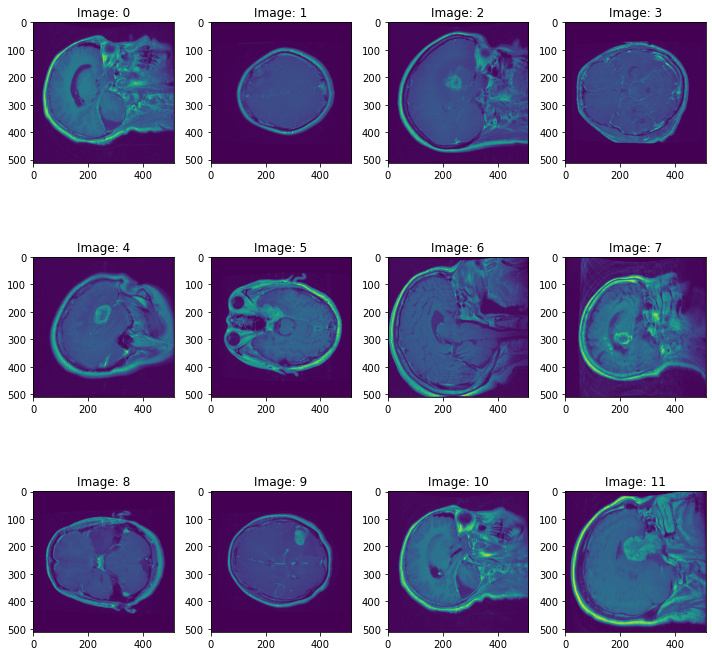

In [64]:
%matplotlib inline


width=8
height=8
rows = 3
cols = 4
axes=[]

fig=plt.figure(figsize=(10,10))

for i in range(rows * cols):
    axes.append( fig.add_subplot(rows, cols, i+1) )
    subplot_title=("Image: "+str(i))
    axes[-1].set_title(subplot_title)  
    plt.imshow(x_train[i].squeeze())
fig.tight_layout()    
plt.show()

In [71]:
from skimage.metrics import structural_similarity as ssim

In [72]:
def compare_images(original, generated):
    '''
    Input:
        original : Original HR Image
        generated : Image Generated by GAN
    return:
        returns psnr and ssim metrics
    '''
    scores = []
    scores.append(cv2.PSNR(original, generated))
    scores.append(ssim(original, generated, multichannel=True))
    
    return scores

In [65]:
def plot_generated_images(epoch,generator, examples=3 , dim=(1, 3), figsize=(15, 5)):
    
    rand_nums = np.random.randint(0, x_test_hr.shape[0], size=examples)
    print('rand_nums: ',rand_nums,' x_test_hr.shape[0]: ', x_test_hr.shape[0])
    image_batch_hr = denormalize(x_test_hr[rand_nums])
    image_batch_lr = np.stack(x_test_lr[rand_nums], axis=0)
    gen_img = generator.predict(image_batch_lr)
    generated_image = denormalize(gen_img)
    image_batch_lr = denormalize(image_batch_lr)
    
    #generated_image = deprocess_HR(generator.predict(image_batch_lr))
    
    plt.figure(figsize=figsize)
    
    plt.subplot(dim[0], dim[1], 1)
    plt.imshow(image_batch_lr[1].squeeze(), interpolation='nearest')
    plt.title('Down Sampled Image')
    plt.axis('off')
        
    plt.subplot(dim[0], dim[1], 2)
    plt.imshow(generated_image[1].squeeze(), interpolation='nearest')
    plt.title('Image Generated by Generator of GAN')
    plt.axis('off')
    
    plt.subplot(dim[0], dim[1], 3)
    plt.imshow(image_batch_hr[1].squeeze(), interpolation='nearest')
    plt.title('Original HR Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('./output/gan_generated_image_epoch_%d.png' % epoch)
    
    ## Printing PSNR AND SSIM
    metrics = compare_images(image_batch_hr[1], generated_image[1])
    
    print('PSNR: ',metrics[0])
    print('SSIM: ', metrics[1])

In [66]:
epochs=1
batch_size=4

In [67]:
downscale_factor = 4
    
batch_count = int(x_train_hr_new.shape[0] / batch_size)
shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, image_shape[2])
# shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, 3)
print('input shape to generator: ',shape)
generator = Generator(shape).generator()
discriminator = Discriminator(image_shape).discriminator()

adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# generator.compile(loss=vgg_loss, optimizer=adam)
generator.compile(loss="binary_crossentropy", optimizer=adam)
discriminator.compile(loss="binary_crossentropy", optimizer=adam)

shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, 1)
print('input shape to discriminator: ',shape)
# shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor)
gan = get_gan_network(discriminator, shape, generator, adam)

input shape to generator:  (128, 128, 1)
generator input:   (None, 128, 128, 1)
output of generator:  <tensorflow.python.keras.engine.functional.Functional object at 0x7f5a9064b7d0>
discriminator input:  (None, 512, 512, 1)
Discriminator output:  <tensorflow.python.keras.engine.functional.Functional object at 0x7f5a9050e0d0>
input shape to discriminator:  (128, 128, 1)


In [68]:
rand_nums = np.random.randint(0, x_train_hr_new.shape[0], size=batch_size)
print(rand_nums, x_train_hr_new.shape[0], batch_size)
image_batch_hr =  np.stack(x_train_hr_new[rand_nums], axis=0)
image_batch_lr = np.stack(x_train_lr_new[rand_nums], axis=0)

print(type(image_batch_hr), image_batch_hr[0].shape, image_batch_hr.shape)
print(type(image_batch_lr),image_batch_lr[0].shape, image_batch_lr.shape)

[265 125 484  15] 498 4
<class 'numpy.ndarray'> (512, 512, 1) (4, 512, 512, 1)
<class 'numpy.ndarray'> (128, 128, 1) (4, 128, 128, 1)


In [69]:
# a = np.zeros((batch_size,512,512,1))
# a.shape
# for i in range(a.shape[0]):
#     a[i] = x_train_hr_new[i]
# print(a)

--------------- Epoch 1 ---------------
Batch No:  0
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-26.465473175048828, -26.469776153564453, 4.302445411682129]
Batch No:  1
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-42.70516586303711, -42.70906066894531, 3.895686149597168]
Batch No:  2
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-48.171600341796875, -48.17596435546875, 4.362148761749268]
Batch No:  3
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-47.440921783447266, -47.44670867919922, 5.788739204406738]
Batch No:  4
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-48.55497360229492, -48.58695983886719, 31.98738670349121]
Batch No:  5
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-49.486915588378906, -49.51641082763672, 29.494083404541016]
Batch No:  6
Loss Mertics:  ['loss', 'functional_1_los

Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-53.73931121826172, -53.740379333496094, 1.0674796104431152]
Batch No:  55
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-54.021366119384766, -54.024559020996094, 3.1937050819396973]
Batch No:  56
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-43.26121520996094, -43.262332916259766, 1.116927146911621]
Batch No:  57
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-44.52717208862305, -44.531211853027344, 4.0389018058776855]
Batch No:  58
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-52.589393615722656, -52.5917854309082, 2.3905692100524902]
Batch No:  59
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-32.69689178466797, -32.69791030883789, 1.017423152923584]
Batch No:  60
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-40.070

Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-52.84003829956055, -52.8451042175293, 5.066315650939941]
Batch No:  109
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-20.169557571411133, -20.176809310913086, 7.251409530639648]
Batch No:  110
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-39.97613525390625, -39.983829498291016, 7.694256782531738]
Batch No:  111
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-26.882259368896484, -26.890031814575195, 7.7730817794799805]
Batch No:  112
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-57.15388870239258, -57.15724563598633, 3.3562512397766113]
Batch No:  113
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-50.49045181274414, -50.50117874145508, 10.726791381835938]
Batch No:  114
Loss Mertics:  ['loss', 'functional_1_loss', 'functional_3_loss']
Gan Loss:  [-43

ValueError: win_size exceeds image extent.  If the input is a multichannel (color) image, set multichannel=True.

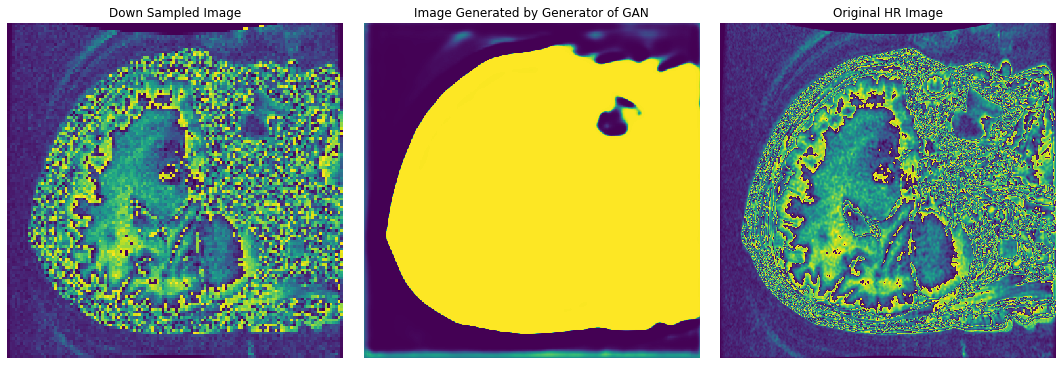

In [73]:
hr_loss, lr_loss, gan_loss = [], [], []

for e in range(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    for i in range(batch_count):
        print('Batch No: ',i)
        rand_nums = np.random.randint(0, x_train_hr_new.shape[0], size=batch_size)

#         image_batch_hr = array(x_train_hr[rand_nums])
#         image_batch_lr = array(x_train_lr[rand_nums])

        image_batch_hr =  np.stack(x_train_hr_new[rand_nums], axis=0)
        image_batch_lr = np.stack(x_train_lr_new[rand_nums], axis=0)
        
#         image_batch_hr = np.zeros((batch_size,512,512,1)) 
#         image_batch_lr = np.zeros((batch_size,128,128,1))
        
#         im_batch_hr =  x_train_hr_new[rand_nums]
#         im_batch_lr = x_train_lr_new[rand_nums]
        
#         for i in range(image_batch_hr.shape[0]):
#             image_batch_hr[i] = im_batch_hr[i]
        
#         for i in range(image_batch_lr.shape[0]):
#             image_batch_lr[i] = im_batch_lr[i]
            
        generated_images_sr = generator.predict(image_batch_lr)

        real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
        fake_data_Y = np.random.random_sample(batch_size)*0.2

        discriminator.trainable = True

        d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
        d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
        #d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

        rand_nums = np.random.randint(0, x_train_hr_new.shape[0], size=batch_size)
#         image_batch_hr = x_train_hr[rand_nums]
#         image_batch_lr = x_train_lr[rand_nums]
#         print(rand_nums,x_train_hr_new[0].shape,x_train_hr_new[1].shape,
#               x_train_hr_new[2].shape,x_train_hr_new[3].shape)
    
        image_batch_hr =  np.stack(x_train_hr_new[rand_nums], axis=0)
        image_batch_lr = np.stack(x_train_lr_new[rand_nums], axis=0)
        
#         image_batch_hr = np.zeros((batch_size,512,512,1)) 
#         image_batch_lr = np.zeros((batch_size,128,128,1))
        
#         im_batch_hr =  x_train_hr_new[rand_nums]
#         im_batch_lr = x_train_lr_new[rand_nums]
        
#         for i in range(image_batch_hr.shape[0]):
#             image_batch_hr[i] = im_batch_hr[i]
        
#         for i in range(image_batch_lr.shape[0]):
#             image_batch_lr[i] = im_batch_lr[i]
            
#         print(image_batch_hr.shape, image_batch_lr.shape)

        gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
#         print('gan_Y; ', gan_Y.shape,' image_batch_size: ', image_batch_hr.shape)
        discriminator.trainable = False
        loss_gan = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])
        print('Loss Mertics: ', gan.metrics_names)
        print('Gan Loss: ', loss_gan)

    print("Loss HR , Loss LR, Loss GAN")
    print(d_loss_real, d_loss_fake, loss_gan)
    hr_loss.append(d_loss_real)
    lr_loss.append(d_loss_fake)
    gan_loss.append(loss_gan)

#     if e == 1 or e % 5 == 0:
#         plot_generated_images(e, generator)
    
    plot_generated_images(e, generator)
    
    if e % 300 == 0:
        generator.save('./output/gen_model%d.h5' % e)
        discriminator.save('./output/dis_model%d.h5' % e)
        gan.save('./output/gan_model%d.h5' % e)

In [ ]:
# def train(epochs=1, batch_size=128):

#     downscale_factor = 4
    
#     batch_count = int(x_train_hr.shape[0] / batch_size)
#     shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, image_shape[2])
    
#     generator = Generator(shape).generator()
#     discriminator = Discriminator(image_shape).discriminator()

#     adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#     generator.compile(loss=vgg_loss, optimizer=adam)
#     discriminator.compile(loss="binary_crossentropy", optimizer=adam)
    
#     shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, 3)
#     gan = get_gan_network(discriminator, shape, generator, adam)

#     for e in range(1, epochs+1):
#         print ('-'*15, 'Epoch %d' % e, '-'*15)
#         for _ in range(batch_count):
            
#             rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            
#             image_batch_hr = x_train_hr[rand_nums]
#             image_batch_lr = x_train_lr[rand_nums]
#             generated_images_sr = generator.predict(image_batch_lr)

#             real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
#             fake_data_Y = np.random.random_sample(batch_size)*0.2
            
#             discriminator.trainable = True
            
#             d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
#             d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
#             #d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            
#             rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
#             image_batch_hr = x_train_hr[rand_nums]
#             image_batch_lr = x_train_lr[rand_nums]

#             gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
#             discriminator.trainable = False
#             loss_gan = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])
            
#         print("Loss HR , Loss LR, Loss GAN")
#         print(d_loss_real, d_loss_fake, loss_gan)

#         if e == 1 or e % 5 == 0:
#             plot_generated_images(e, generator)
#         if e % 300 == 0:
#             generator.save('./output/gen_model%d.h5' % e)
#             discriminator.save('./output/dis_model%d.h5' % e)
#             gan.save('./output/gan_model%d.h5' % e)

In [ ]:
# train(20000, 4)
# train(20,4)

In [ ]:
# def psnr(original, generated):
#     original_data = original.astype(np.float32)
#     generated_data = generated.astype(np.float32)
    
#     diff = generated_data - original_data
#     diff = diff.flatten('C')
    
#     rmse = np.sqrt(np.mean(diff ** 2.))
    
#     return 20 * np.log10(255. / rmse)

In [ ]:
# def compare_images(original, generated):
#     '''
#     Input:
#         original : Original HR Image
#         generated : Image Generated by GAN
#     return:
#         returns psnr and ssim metrics
#     '''
#     scores = []
#     scores.append(cv2.PSNR(original, generated))
#     scores.append(ssim(original, generated, multichannel=False))
    
#     return scores